# FDS Lab S2-03: Estimation, including confidence intervals...

Welcome to second lab in Semester 2.

**Learning outcomes:** In this lab you will use statistical simulations to undertake bootstrap estimation of confidence intervals. Along the way we will start to think about basic software engineering aspects of data science programming. By the end of this lab you should be able to:
- code the bootstrap estimator for a number of estimators
- validate statistical coding by comparing the output of functions with known results
- interpret the output
- compare the output with confidence intervals obtained by other methods
We will go over simulations and randomness, from the topic on "Estimation".

Let us start, as usual, by importing the necessary libraries set up the imports by running the cell below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


# 1. Bootstrap - confidence intervals in baseball data

We'll finish off what we started in the previous lab. We'd like to generate confidence intervals for various statistics in the baseball dataset. First we'll load the data

In [2]:
player_data = pd.read_csv("datasets/player_data.csv")
salary_data = pd.read_csv("datasets/salary_data.csv")
full_data = pd.merge(salary_data, player_data,
                     left_on="PlayerName", right_on="Name")
full_data['Salary']=full_data['Salary']/1000000

In [3]:
salary_data.head()

,PlayerName,Salary
0,Kobe Bryant,23500000
1,Amar'e Stoudemire,23410988
2,Joe Johnson,23180790
3,Carmelo Anthony,22458401
4,Dwight Howard,21436271


**Exercise 01:** Using the code from last week, and the information in the lecture notes, write the a bootstrap estimation routine with $k=1000$ replications to:
1. plot the sampling distribution of the mean.
2. find a 95% confidence interval for the mean of the salary data.

(array([   4.,    7.,   49.,  136.,  299.,  548.,  884., 1270., 1500.,
        1516., 1376., 1005.,  705.,  362.,  188.,  102.,   28.,   14.,
           3.,    4.]),
 array([3.49790312, 3.58124227, 3.66458141, 3.74792056, 3.8312597 ,
        3.91459884, 3.99793799, 4.08127713, 4.16461627, 4.24795542,
        4.33129456, 4.4146337 , 4.49797285, 4.58131199, 4.66465114,
        4.74799028, 4.83132942, 4.91466857, 4.99800771, 5.08134685,
        5.164686  ]),
 <BarContainer object of 20 artists>)

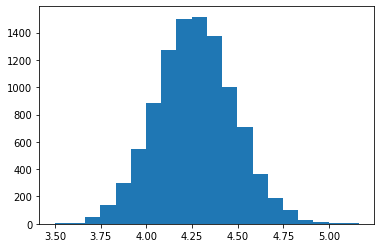

In [4]:
salaries = full_data['Salary']
k = 10000
n = len(salary_data)

x_star_tilde = np.zeros(k)
for i in range(k):
    x_star = salaries.sample(n, replace=True)
    x_star_tilde[i] = x_star.mean()
    
    
plt.hist(x_star_tilde, 20)


In [5]:
print("Confidence interval")
print(pd.Series(x_star_tilde).quantile([0.025, 0.975]))
    

Confidence interval
0.025    3.853260
0.975    4.697401
dtype: float64


## Engineering a bootstrap function

**Exercise 02:** When you find you're using the same piece of code repeatedly, it's good to turn it into a function. Write a function called bootstrap(), which takes as its input arguments
1. `x`: pd.Series()
3. `estimator`: The function (e.g. `np.mean`) that you would like to get the bootstrap confidence intervals for. Note that you can pass functions as arguments to python functions.
4. `quantiles`: An array containing the desired quantiles
5. `plot`: Boolean indicating if a plot of the bootstrap distribution of the estimator should be shown. `False` by default.
 
It should return:
1. the quantiles
2. the bootstrap standard deviation

0.20759079442202139


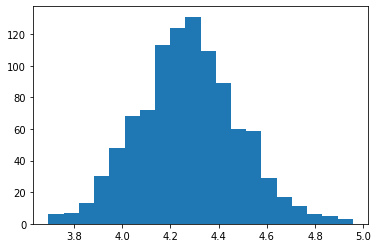

In [6]:
def bootstrap(x, k=1000, estimator=np.mean, quantiles=[0.025, 0.975], plot=False):
    n = len(x)
    x_star_est = np.zeros(k)
    for i in range(k):
        x_star = np.random.choice(x, n, replace=True)
        x_star_est[i] = estimator(x_star)
        
    if (plot):
        plt.hist(x_star_est, 20)
    return(np.quantile(x_star_est, quantiles), np.std(x_star_est))

quantiles, std = bootstrap(salaries, plot=True)
print(std)

## Testing the function

It's good to test that your code works as you expect it to on something that you know the answer for. In this, artificial, case we know the distribution, so we can estimate the SEM as $\sigma_{\overline{X} = \sigma/\sqrt{n}$. 

**Exercise 03:** 
- Compare the SEM computed from the full distribution with the bootstrap estimates.
- Are they of a similar size? If so, good - if not, go back and check the bootstrap function.
- Compare the quantiles produced by the function with the distribution produced with `plot=True`. Do the quantiles lie in the distribution?

In [7]:
SEM = np.std(salaries)/np.sqrt(len(salaries))
SEM

0.2149839356734121

0.2069091352083499 [3.88224812 4.69128623]


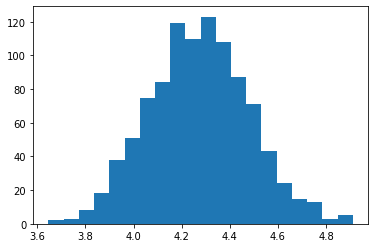

In [8]:
quantiles, std = bootstrap(salaries, plot=True)
print(std, quantiles)

Your answer:
    
The SEM of the distribution and the estimated SEM computed from the bootstrap estimator are similar. The quantiles look about right too, compared to the distribution.

## Apply the bootstrap function to the median

**Exercise 05:** Apply your new bootstrap function to the confidence intervals of the median of the salaries, plotting the distribution.

(array([2.023261, 2.873764]), 0.23683754541367702)

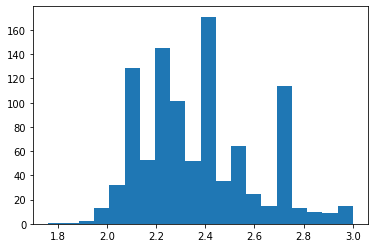

In [9]:
bootstrap(salaries, 1000, estimator=np.median, plot=True)

**Discussion:** Does the distribution of the sample median look as you would expect it to? If not, what is unusual about it? Can you explain why you're seeing this?

Your answer:
    
The bootstrap distribution does not look as I expected it to. It looks bumpy. This is probably because there are some very common exact amounts of salaries, meaning the median gets stuck there.

In [10]:
x_star_tilde

array([4.41864001, 4.42148894, 4.30193278, ..., 4.27151982, 4.35040516,
       3.83874384])

# 2. Bootstrap applied to linear regression -  output from other packages

As we've said in the lectures, we can apply the bootstrap estimator to many different types of statistic, where by "statistic" we mean a value derived from the data. Linear regression coefficients also count as statistics - so we should be able to used the bootstrap on them.
 
 **Exercise 06:** 
 - Create a new column of `full_data` called `LogSalary`, which is the log to the base 10 of `Salary`.
 - Plot the `LogSalary` against the `Age`.
 - Fit a linear regression of the `LogSalary` to the `Age` using `statsmodels`. (See the linear regression lab).
 - Extract the best fitting Intercept and Age parameters from the result

In [11]:
import seaborn as sns
import statsmodels.formula.api as smf
# sns.pairplot(full_data)

In [12]:
full_data['LogSalary'] = np.log10(full_data['Salary'])

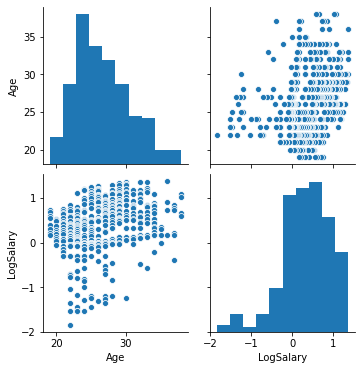

In [13]:
sns.pairplot(full_data, vars=['Age', 'LogSalary'])

In [14]:
## Maybe we should give this?
model = smf.ols('LogSalary ~ Age', data=full_data)
results = model.fit()
results.params

Intercept   -0.797333
Age          0.042749
dtype: float64

**Exercise 07:** Now use the code to write a function `beta0hat` that, given a data frame `df` with the same format as `full_data` returns the fitted intercept. Test that it gets the correct results, when given full_data as an argument.

In [15]:
def beta0hat(dat):
    model = smf.ols('LogSalary ~ Age', data=dat)
    results = model.fit()
    return(results.params['Intercept'])

beta0hat(full_data)

-0.7973333757451672

**Exercise 08:** 
- Write a function `bootstrap_df`, which is the same as `bootstrap`, but in which the estimator can take a DataFrame as an argument, and return a statistic (i.e., just like the function `beta0hat` does).
- Write a function `salary_mean()` that returns the mean of the `Salary` column of a data frame, and use it to verify that `bootstrap_df` gives similar results to the ones you obtained above.

In [16]:
def bootstrap_df(x, k=1000, estimator=np.mean, quantiles=[0.025, 0.975], plot=False):
    n = len(x)
    x_star_est = np.zeros(k)
    for i in range(k):
        x_star = x.sample(n, replace=True)
        x_star_est[i] = estimator(x_star)
        
    if (plot):
        plt.hist(x_star_est, 20)
    return(np.quantile(x_star_est, quantiles), np.std(x_star_est))

def salary_mean(dat):
    return(dat['Salary'].mean())

bootstrap_df(full_data, estimator=salary_mean)

(array([3.84540742, 4.66515542]), 0.2138717949634379)

**Exercise 09:**
Now apply the `bootstrap_df` function to get confidence intervals of the `Intercept` of the linear regression of `Age` on `LogSalary`.

In [17]:
bootstrap_df(full_data, estimator=beta0hat)

(array([-1.08333573, -0.5319953 ]), 0.1437336470266089)

**Discussion:** Does the confidence interval contain the value of estimated `Intercept`?

**Exercise 10:** Create a function `beta1hat` that returns the fitted slope (`Age`) parameter. Apply `boodstrap_df` to it to return confidence interval and standard error in the estimator.

In [18]:
def beta1hat(dat):
    model = smf.ols('LogSalary ~ Age', data=dat)
    results = model.fit()
    return(results.params['Age'])

bootstrap_df(full_data, estimator=beta1hat)

(array([0.03323944, 0.05334911]), 0.005183671363440526)

# 3 Comparison of bootstrap and theoretical confidence interval

In this example, we don't actually have to use the bootstrap to estimate the confidence intervals; statsmodels (and many other packages) can estimate the standard error of the sampling distribution of the estimator. Run the statsmodels fit again, but this time report all the output using the `summary`.

In [19]:
## Maybe we should give this?
model = smf.ols('LogSalary ~ Age', data=full_data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              LogSalary   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     51.14
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           3.15e-12
Time:                        23:45:01   Log-Likelihood:                -407.87
No. Observations:                 492   AIC:                             819.7
Df Residuals:                     490   BIC:                             828.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7973      0.161     -4.965      0.000      -1.113      -0.482
Age            0.0427      0.006      7.151      0.000       0.031       0.054
==============================================================================
Omnibus:                       58.598   Durbin-Watson:                   0.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.073
Skew:                          -0.838   Prob(JB):                     1.51e-18
Kurtosis:                       4.094   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Look at the middle table of the results, containing the `Intercept` and `Age` variables. In semester 1 we learned how to interpret the `coeff` column. We should now be able to understand the `std err` and `[0.025` and `0.975]` columns. 
- `coeff`: best estimate of `Intercept` and `Age`
- `std err`: the standard error of the estimators of `Intercept` and `Age`
- `[0.025`: lower bound of the 95% confidence interval of the estimators of `Intercept` and `Age`
- `0.025]`: upper bound of the 95% confidence interval of the estimators of `Intercept` and `Age`

**Discussion**:
- Are the standard errors reported here close to the bootstrap estimates? 
- Are the confidence intervals close to the bootstrap estimates?
- Is the number 0 contained in either of the 95% confidence intervals?

Your answer

- Yes the standard errors are close
- Yes the confidence intervals are close
- No, the number 0 is not contained in either of the confidence intervals

**Explanation:** The `t` column refers to the `t` statistic: 

$t = \frac{\hat\theta - 0}{\hat\sigma_{\hat\theta}}$

You can check that `t` does indeed equal the coefficient divided by the standard error.

It has to do with a hypothesis test. The null and alternative hypotheses are:

$H_0$: The true value of the parameter is equal to zero

$H_\mathrm{a}$: The parameter is equal to something else

Due to the duality between confidence intervals and hypothesis testing, to test the null hypothesis we can consider the area in the tail of the sampling distribution beyond 0 to be the *p*-value. In the case of both the Age and the Salary, this *p*-value `P>|t|` is 0.  